In [1]:
# Import libraries
from google.colab import drive
import os
import sys
import time
import numpy as np
import pandas as pd
import math
from scipy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.utils import np_utils
import cv2
import ssl
import urllib.request
from urllib.request import ProxyHandler, build_opener, install_opener, urlretrieve

In [2]:
# Connect with Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
# import utils
py_file_location = "/content/drive/My Drive/DataScience"
sys.path.append(os.path.abspath(py_file_location))
from utils import load_data, get_prediction, url_to_image, predict_url

In [5]:
class_names = ['indoor selfie', 'outdoor selfie', 'indoor pose', 'outdoor pose', 'no human']

# Load test data

In [6]:
X_test = load_data('/content/drive/My Drive/DataScience/Test Data/', 'dataset_test.pickle')
y_test = load_data('/content/drive/My Drive/DataScience/Test Data/', 'labels_test.pickle')

# Preprocessing

In [7]:
# Check datatype and value range
print(X_test.dtype)
print(np.max(X_test))
print(np.min(X_test))

float32
255.0
0.0


In [8]:
# Normalize the dataset:
X_test = X_test/255.0

In [9]:
# Save original labels
y_test1 = y_test

In [10]:
# One hot encode outputs
y_test = y_test.reshape(-1,1)
y_test.shape

y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

# Model load

In [11]:
model = load_model('/content/drive/My Drive/DataScience/Models/best_model_mobile.pt')

# Model predict

In [12]:
# Get probabilities
pred = model.predict(X_test)

# Get predicted class
predictions = []
for i in range(y_test1.shape[0]):
  predictions.append(np.argmax(pred[i]))

# Benchmark

## Accuracy

In [14]:
# Accuracy
accuracy_score(y_test1, predictions)

1.0

## Confusion matrix


Confusion matrix 



Text(0.5, 1.0, 'Confusion Matrix')

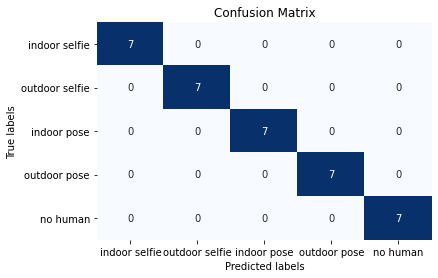

In [15]:
print('Confusion matrix \n')
cm = confusion_matrix(y_test1, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

ax= plt.subplot()
sns.heatmap(df_cm, cmap='Blues', annot=True, cbar =False, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## Precision/Recall


In [16]:
print('Classification report \n')
print(classification_report(y_test1, predictions, target_names = class_names))

Classification report 

                precision    recall  f1-score   support

 indoor selfie       1.00      1.00      1.00         7
outdoor selfie       1.00      1.00      1.00         7
   indoor pose       1.00      1.00      1.00         7
  outdoor pose       1.00      1.00      1.00         7
      no human       1.00      1.00      1.00         7

      accuracy                           1.00        35
     macro avg       1.00      1.00      1.00        35
  weighted avg       1.00      1.00      1.00        35



## Roc curves

In [17]:
# Calculate ROC AUC Score
n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw =2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


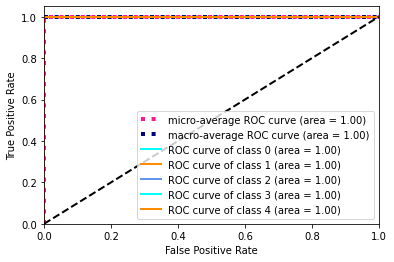

In [18]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Hardware

Average prediction time 2.309877038002014


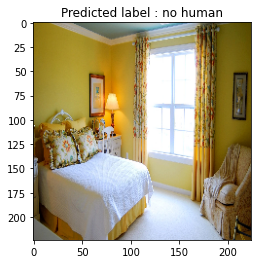

In [19]:
t = []
for i in range(10):
  start = time.time()
  predict_url('https://interior777.com/wallpapers/big/interior_design_0stil-interer-komnata0_image_big_1920x1080.jpg', model, class_names)
  end = time.time()
  t.append(end-start)

print("Average prediction time", sum(t) / len(t))

## Image from url

In [20]:
ssl._create_default_https_context = ssl._create_unverified_context
proxy = ProxyHandler({})
opener = build_opener(proxy)
opener.addheaders = [('User-Agent','Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/603.1.30 (KHTML, like Gecko) Version/10.1 Safari/603.1.30')]
install_opener(opener)

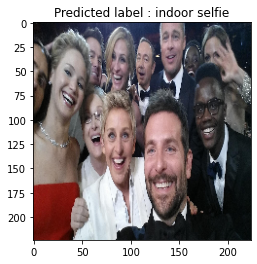

In [21]:
predict_url('https://pbs.twimg.com/media/BhxWutnCEAAtEQ6?format=jpg&name=large', model, class_names)

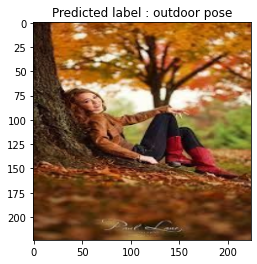

In [22]:
predict_url("https://i.pinimg.com/564x/75/a1/10/75a11040555ec21814ef12dec0d722c8.jpg", model, class_names)

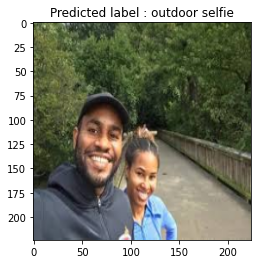

In [23]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT_Lmku2Gdil4qtKhtR_WQAZC4Tt61skT0PPw&usqp=CAU', model, class_names)

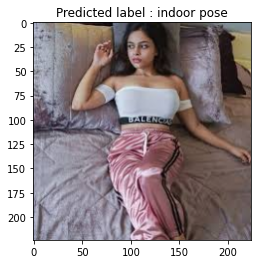

In [24]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSngIvIJvbGHrmur-AxElUWgCIDIU-TR2L5Dw&usqp=CAU', model, class_names)

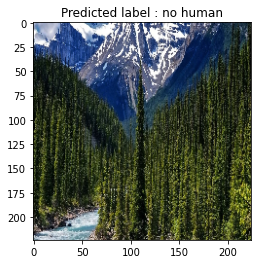

In [26]:
predict_url('https://thewallpaper.co/wp-content/uploads/2020/06/monitor-dual-screen-widescreen-nature-images-multi-water-river-jpg.jpg', model, class_names)